In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, roc_curve, auc, classification_report
import shap
import joblib

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Load the data
df = pd.read_csv('node1_data.csv')

In [3]:
# Charging station locations
CHARGING_STATIONS = [150, 270, 460]

# Create new columns 'distance_to_station_1', 'distance_to_station_2', and 'distance_to_station_3'
df['distance_to_station_1'] = abs(df['distance_covered'] - CHARGING_STATIONS[0])
df['distance_to_station_2'] = abs(df['distance_covered'] - CHARGING_STATIONS[1])
df['distance_to_station_3'] = abs(df['distance_covered'] - CHARGING_STATIONS[2])

# Create a new column 'distance_remaining'
df['distance_remaining'] = 600 - df['distance_covered']

In [4]:
# Feature Selection
features = [
    'current_speed', 'charge', 'consumption', 'distance_covered', 
    'battery_capacity', 'battery_life', 'weather', 'traffic', 
    'road_gradient', 'emergency', 'distance_to_station_1',
    'distance_to_station_2', 'distance_to_station_3', 'distance_remaining'
]

# Create X and y
X = df[features]
# target variable is now the distance to the next charging point
y = df['distance_to_charging_point']

In [5]:
# Model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# for columns with categorical data, create dummy variables
df = pd.get_dummies(df, columns=['weather', 'traffic', 'road_gradient', 'emergency'])

# Check the column names
print(df.columns)

Index(['timestamp', 'car_id', 'model', 'current_speed', 'battery_capacity',
       'charge', 'consumption', 'location', 'node', 'car_status',
       'distance_covered', 'battery_life', 'distance_to_charging_point',
       'emergency_duration', 'distance_to_station_1', 'distance_to_station_2',
       'distance_to_station_3', 'distance_remaining', 'weather_rainy',
       'weather_snowy', 'weather_sunny', 'traffic_heavy', 'traffic_light',
       'traffic_moderate', 'road_gradient_downhill', 'road_gradient_flat',
       'road_gradient_uphill', 'emergency_accident_ahead', 'emergency_none',
       'emergency_road_closure'],
      dtype='object')


In [7]:
# Update the features list accordingly
features = ['current_speed', 'charge', 'consumption', 'distance_covered', 
            'battery_capacity', 'battery_life', 'distance_to_charging_point',
            'weather_sunny', 'weather_rainy', 'weather_snowy', 'traffic_light', 
            'traffic_moderate', 'traffic_heavy', 'road_gradient_flat', 
            'road_gradient_downhill','road_gradient_uphill',
            'emergency_accident_ahead', 'emergency_none', 'emergency_road_closure', 
            'distance_to_station_1', 'distance_to_station_2', 'distance_to_station_3', 
            'distance_remaining']

X = df[features]
y = df['distance_to_charging_point']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestRegressor(random_state=42)
clf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [9]:
# Model evaluation
y_pred = clf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")

Mean Absolute Error: 0.02


In [10]:
# Create a copy of the DataFrame slice
X = X.copy()

# Display columns which contain 'inf' or '-inf' values
inf_columns = X.columns[X.isin([float('inf'), -float('inf')]).any()].tolist()
print(f"Columns with inf values: {inf_columns}")

# Replace 'inf' and '-inf' values in those columns with NaN
for col in inf_columns:
    X[col].replace([float('inf'), -float('inf')], float('nan'), inplace=True)

# replacing NaN with the mean of the column
for col in inf_columns:
    X[col].fillna(X[col].mean(), inplace=True)

Columns with inf values: []


In [11]:
# Using 5-fold cross-validation
scores = cross_val_score(clf, X, y, cv=5)

# Display the scores for each fold
for i, score in enumerate(scores, 1):
    print(f"Fold-{i} Accuracy: {score:.4f}")

# Display the average accuracy across all folds
print(f"\nAverage Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

Fold-1 Accuracy: 1.0000
Fold-2 Accuracy: 1.0000
Fold-3 Accuracy: 1.0000
Fold-4 Accuracy: 1.0000
Fold-5 Accuracy: 1.0000

Average Accuracy: 1.0000 ± 0.0000


In [12]:
# Train the classifier on the entire dataset for this demonstration
clf.fit(X, y)
importances = clf.feature_importances_

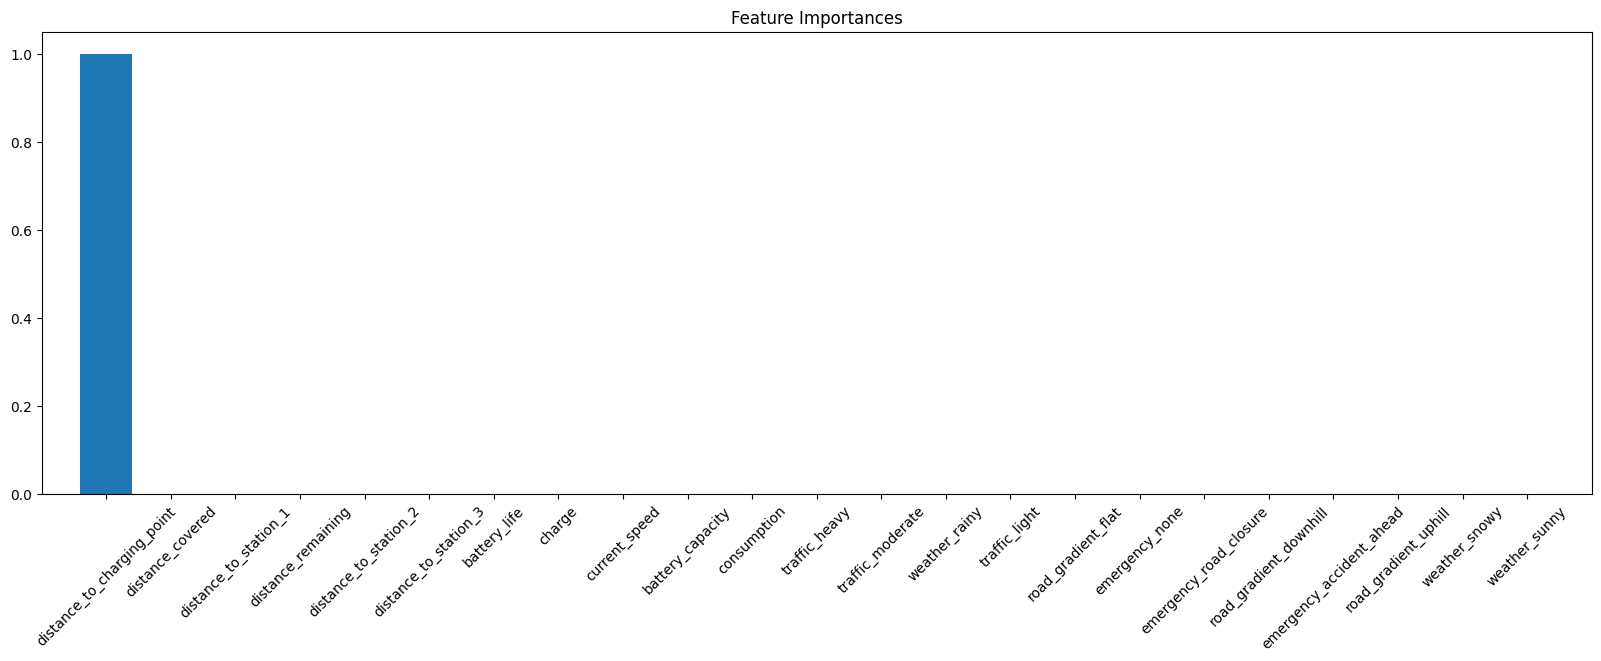

In [13]:
# Visualizing feature importances
plt.figure(figsize=(20, 6))
indices = np.argsort(importances)[::-1]
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(features)[indices], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()

In [14]:
# Parameters to tune
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   4.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   3.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   3.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   3.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   3.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]},
             verbose=2)

In [15]:
# Best parameters from grid search
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150}


In [16]:
# Train a new model with the best parameters
best_clf = RandomForestRegressor(**best_params, random_state=42)
best_clf.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=4, n_estimators=150, random_state=42)

In [17]:
# Evaluate the new model
y_pred = best_clf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")

Mean Absolute Error: 0.02


In [18]:
# Save the model
filename = 'best_model.pkl'
joblib.dump(best_clf, filename)

print("Model saved as ", filename)

Model saved as  best_model.pkl


In [19]:
# Load the model
loaded_model = joblib.load(filename)

In [20]:
# Make predictions
y_pred = loaded_model.predict(X_test)

In [21]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")

Mean Absolute Error: 0.02


In [22]:
# SHAP (SHapley Additive exPlanations) is a unified measure of feature importance and model interpretability based on Shapley values.
explainer = shap.TreeExplainer(loaded_model)
shap_values = explainer.shap_values(X)

In [23]:
# Visualize the SHAP values for a single prediction
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


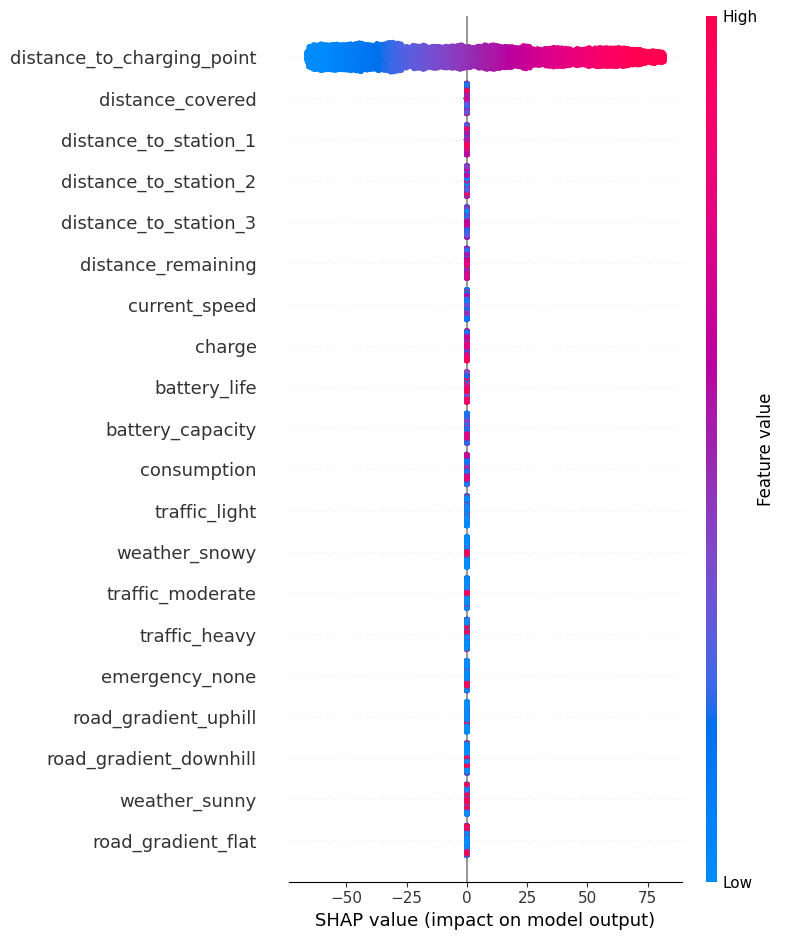

In [24]:
# Visualize the SHAP values for the entire dataset
shap.summary_plot(shap_values, X)